In [1]:
import torch 
from torchvision.models import resnet50,ResNet50_Weights,resnet152,ResNet152_Weights
import torchvision
import os
os.environ['TORCH_HOME']=r"D:\torch_model"

In [2]:
weights = torchvision.models.ResNet152_Weights.IMAGENET1K_V1
net = torchvision.models.resnet152(weights=weights)

In [3]:
from d2l import torch as d2l
from torch.utils.data import DataLoader,Dataset,Subset

transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[.5, .5, .5], std=[.5, .5, .5]),
])
dataset=torchvision.datasets.ImageFolder(root=r'D:\project_meta\NNproject\NNI\output\video_frames',transform=transforms)



In [4]:
from sklearn.model_selection import train_test_split
import datetime
indexs=torch.tensor(range(len(dataset)))
train_dataset_index,test_dataset_index=train_test_split(indexs,test_size=0.3,shuffle=True)
train_dataset=Subset(dataset=dataset,indices=train_dataset_index)
test_dataset=Subset(dataset=dataset,indices=test_dataset_index)
train_dataloader=DataLoader(train_dataset,batch_size=128)
test_dataloader=DataLoader(test_dataset,batch_size=256)

timer, num_batches = d2l.Timer(), len(train_dataloader)
 



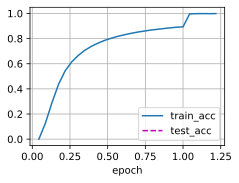

In [5]:
import torch.nn.functional as F
import torch
device=torch.device('cuda')
net=resnet50(weights=ResNet50_Weights.DEFAULT).to(device)
optim=torch.optim.SGD(net.parameters(),lr=0.05,weight_decay=5e-4)
loss=torch.nn.CrossEntropyLoss().to(device="cuda")
num_epochs=500
best_train_acc=0
best_train_loss=0
best_test_acc=0
stagnate_times=0
temp_acc=0
current_time = datetime.datetime.now()
formatted_time = current_time.strftime("%Y_%m_%d_%H_%M_%S")
parameterFolder=os.path.join(r"D:\project_meta\NNproject\NNI\output\model_parameter\FilterSignalCNN1D",f"{formatted_time}")
print(parameterFolder)
os.makedirs(parameterFolder)
animator = d2l.Animator(xlabel='epoch',
                        legend=['train_acc','test_acc'])  
for epoch in range(num_epochs):
    metric_train = d2l.Accumulator(2)
    net.train()
    for i,data_dict in enumerate(train_dataloader):
        optim.zero_grad()
        x=data_dict[0].to(device)
        x=x+torch.randn_like(x).to(device) /100   
        y=data_dict[1].long().to(device)
        y_hat=net(x)
        l=F.cross_entropy(y_hat, y)
        l.mean().backward()
        optim.step()     
        pre=torch.argmax(y_hat.detach().cpu(),dim=1)
        num_true=sum(pre==y.cpu())
        metric_train.add(num_true,y.numel())
        
        if (i + 1) % (num_batches // 20) == 0 or i == num_batches - 1:
            animator.add(epoch + (i + 1) / num_batches, (metric_train[0]/metric_train[1],None))
        
    
    net.eval()
    with torch.no_grad():
        metric_test = d2l.Accumulator(2)
        for data_dict in test_dataloader:
            x=data_dict[0].to(torch.float32).to(device)
            y=data_dict[1].long().to(device)
            y_hat=net(x)
            pre=torch.argmax(y_hat.detach().cpu(),dim=1)
            num_true=sum(pre==y.cpu())
            metric_test.add(num_true,y.numel())
        animator.add(epoch+ 1, (None,metric_test[0]/metric_test[1]))

        if best_test_acc<(metric_test[0]/metric_test[1]):
            best_test_acc=metric_test[0]/metric_test[1]
            stagnate_times=0
            
            
            torch.save(net.state_dict(),os.path.join(parameterFolder,f'{best_test_acc}.pt'))
        else:
            stagnate_times=stagnate_times+1
        
        if stagnate_times>50:
            break

In [9]:
print(num_batches )

46


In [ ]:
torch.cuda.empty_cache()

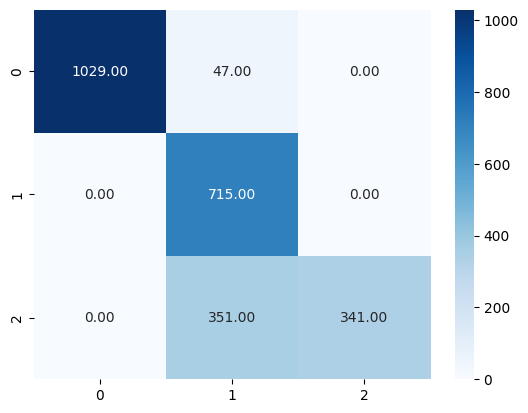

In [2]:
import torch 
from torchvision.models import resnet50,ResNet50_Weights,resnet152,ResNet152_Weights
import torchvision
import os
os.environ['TORCH_HOME']=r"D:\torch_model"
from sklearn.model_selection import train_test_split
import datetime
from d2l import torch as d2l
from torch.utils.data import DataLoader,Dataset,Subset

transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[.5, .5, .5], std=[.5, .5, .5]),
])
dataset=torchvision.datasets.ImageFolder(root=r'D:\project_meta\NNproject\NNI\output\video_frames',transform=transforms)
indexs=torch.tensor(range(len(dataset)))
train_dataset_index,test_dataset_index=train_test_split(indexs,test_size=0.3,shuffle=True)
train_dataset=Subset(dataset=dataset,indices=train_dataset_index)
test_dataset=Subset(dataset=dataset,indices=test_dataset_index)
train_dataloader=DataLoader(train_dataset,batch_size=128)
test_dataloader=DataLoader(test_dataset,batch_size=256)
from sklearn.metrics import confusion_matrix
import numpy as np
torch.cuda.empty_cache()
device=torch.device('cuda')
net=resnet50(weights=ResNet50_Weights.DEFAULT).to(device)
net.eval()
with torch.no_grad():
    num_classes=3
    test_dataloader=DataLoader(test_dataset,batch_size=128)
    confusion_matrix_test = np.zeros((num_classes, num_classes))
    net.load_state_dict(torch.load(r"D:\project_meta\NNproject\NNI\output\model_parameter\FilterSignalCNN1D\2023_11_08_13_10_32\0.842126459927507.pt"))
    for data_dict in test_dataloader:
        x=data_dict[0].to(torch.float32).to(device)
        y=data_dict[1].long().to(device)
        y_hat=net(x)
        pre=torch.argmax(y_hat.detach().cpu(),dim=1)
        num_true=sum(pre==y.cpu())
        y_pred = torch.stack((pre, y.cpu()), dim=1)
        confusion_matrix_test += confusion_matrix(y_pred[:, 1], y_pred[:, 0], labels=range(num_classes))
    import seaborn as sns
    sns.heatmap(confusion_matrix_test,annot=True, fmt=".2f", cmap="Blues")